<a href="https://colab.research.google.com/github/wilberquito/melanoma.thesis/blob/main/Code/pytorch/notebooks/resnet18/ResNet18Regularization_V2_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet18 Regularization V2, performance

In [1]:
!pip install wandb >/dev/null 2>&1

In [2]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 7.5 MB/s eta 0:00:00
mlxtend version: 0.22.0


In [3]:
import requests
from pathlib import Path
import pandas as pd
import seaborn as sns
from zipfile import ZipFile

try:
    import google.colab
    from google.colab import drive
    IN_COLAB = True
    drive.mount('/content/drive')
except:
    IN_COLAB = False

print(f"In colab: {IN_COLAB}")

Mounted at /content/drive
In colab: True


In [4]:
def pull_code():
  print("Unzipping the code from google drive")
  !rm -rf modular/
  !unzip ./drive/MyDrive/wilberquito_thesis/modular.zip -d . >/dev/null 2>&1

if IN_COLAB:
    pull_code()

Unzipping the code from google drive


In [5]:
def pull_data():
  answer = input("You sure? Y/n\n")
  if answer != "Y":
    return

  print("Unzipping the data from google drive")
  !rm -rf data.etl/
  !unzip ./drive/MyDrive/wilberquito_thesis/data.zip -d . >/dev/null 2>&1

if IN_COLAB:
    pull_data()

You sure? Y/n
Y
Unzipping the data from google drive


In [ ]:
!nvidia-smi

Mon Jul 10 09:04:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
def pull_model():
  print("Loading models from google drive")
  !rm -rf resnet18regularization_v2.pth.tar
  !cp ./drive/MyDrive/wilberquito_thesis/models/resnet18/resnet18regularization_v2.pth.tar . >/dev/null 2>&1

if IN_COLAB:
    pull_model()

Loading models from google drive


In [7]:
import torch
import modular.utility as m_utility
import modular.models as m_models


model_path = 'resnet18regularization_v2.pth.tar'
checkpoint = torch.load(model_path)

## Train vs Validate curves

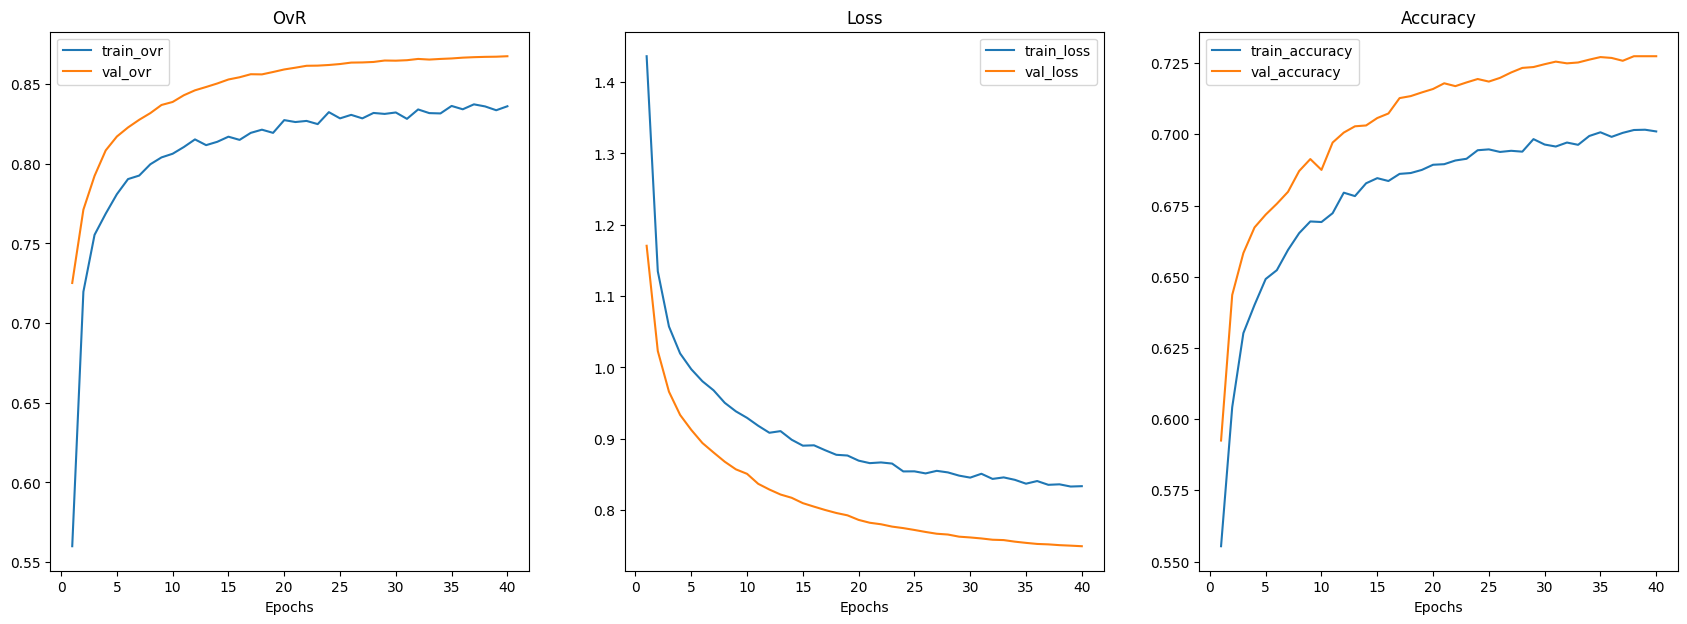

In [ ]:
m_utility.plot_curves(checkpoint['stats'])

## Train

### Melanoma VS Others (AUC - OVR)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1765: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 257MB/s]


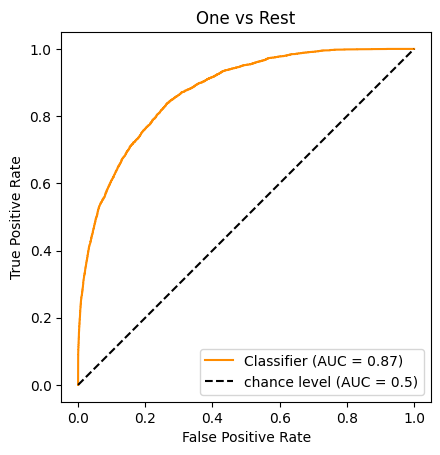

In [ ]:
import torch
import torchvision as tv
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import (ResNet18_Weights)
import torchvision.models as models
import modular.dataset as m_dataset
import modular.utility as m_utility
import modular.models as m_models


# Set seed
m_utility.set_seed(42)

# Build the dataframes
data_dir = 'data.etl'
data_folder = '512'
train_df, _, mapping = m_dataset.get_df(data_dir, data_folder)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 512

# Mapping from id to classname
idx_to_class = { k : classname for classname, k in mapping.items() }

# Train and validate dataset & dataloader
train_df, validate_df = m_dataset.train_validate_split(train_df,
                                                       random_state=42,
                                                       validate_size=0.2)


_, val_transforms = m_dataset.get_transforms(image_size=256)

dataset = m_dataset.MelanomaDataset(train_df,
                                    mode='train',
                                    transforms=val_transforms,
                                    idx_to_class=idx_to_class)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
class_names = [name for k,name in dataset.idx_to_class.items()]

out_features = len(mapping)
model = m_models.ResNet18_Dropout_Melanoma(out_features)
model = model.to(device)

model_state_dict = checkpoint['model_state_dict']
model.load_state_dict(model_state_dict)
model = model.to(device)

MEL_IDX = 6 # Check data exploration notebook

m_utility.plot_ovr_multiclass_roc(model,
                                  MEL_IDX,
                                  dataloader,
                                  device,
                                  val_times=4)

### Confusion Matrix

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1765: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


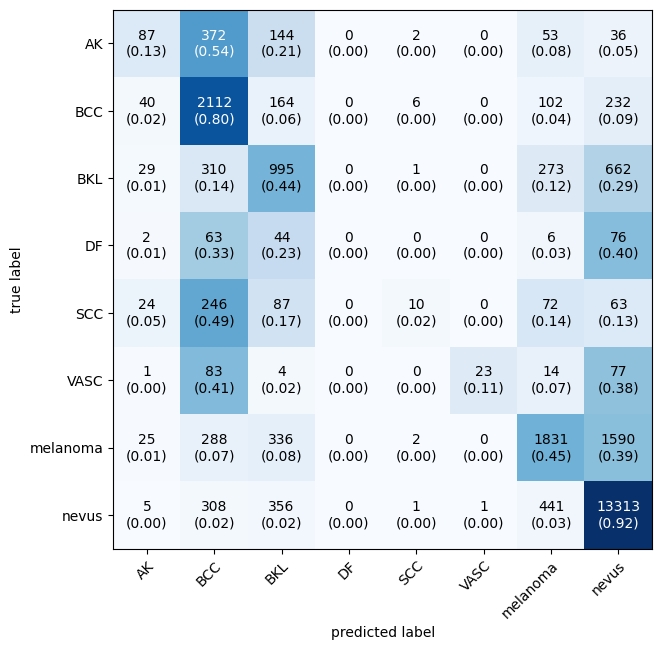

In [ ]:
import torch
import torchvision as tv
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import (ResNet18_Weights)
import torchvision.models as models
import modular.dataset as m_dataset
import modular.utility as m_utility
import modular.models as m_models


# Set seed
m_utility.set_seed(42)

# Build the dataframes
data_dir = 'data.etl'
data_folder = '512'
train_df, _, mapping = m_dataset.get_df(data_dir, data_folder)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 512

# Mapping from id to classname
idx_to_class = { k : classname for classname, k in mapping.items() }


# Train and validate dataset & dataloader
train_df, validate_df = m_dataset.train_validate_split(train_df,
                                                       random_state=42,
                                                       validate_size=0.2)

_, val_transforms = m_dataset.get_transforms(image_size=256)

dataset = m_dataset.MelanomaDataset(train_df,
                                    mode='train',
                                    transforms=val_transforms,
                                    idx_to_class=idx_to_class)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
class_names = [name for k,name in dataset.idx_to_class.items()]

out_features = len(mapping)
model = m_models.ResNet18_Dropout_Melanoma(out_features)
model = model.to(device)

model_state_dict = checkpoint['model_state_dict']
model.load_state_dict(model_state_dict)
model = model.to(device)

m_utility.plot_confusion_matrix(model,
                                dataloader,
                                class_names,
                                device,
                                show_normed=True)

### Resume

In [8]:
import torch
import torchvision as tv
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import (ResNet18_Weights)
import torchvision.models as models
import modular.dataset as m_dataset
import modular.utility as m_utility
import modular.models as m_models


# Set seed
m_utility.set_seed(42)

# Build the dataframes
data_dir = 'data.etl'
data_folder = '512'
train_df, _, mapping = m_dataset.get_df(data_dir, data_folder)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 512

# Mapping from id to classname
idx_to_class = { k : classname for classname, k in mapping.items() }

# Train and validate dataset & dataloader
train_df, validate_df = m_dataset.train_validate_split(train_df,
                                                       random_state=42,
                                                       validate_size=0.2)


_, val_transforms = m_dataset.get_transforms(image_size=256)

dataset = m_dataset.MelanomaDataset(train_df,
                                    mode='train',
                                    transforms=val_transforms,
                                    idx_to_class=idx_to_class)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
class_names = [name for k,name in dataset.idx_to_class.items()]

out_features = len(mapping)
model = m_models.ResNet18_Dropout_Melanoma(out_features)
model = model.to(device)

model_state_dict = checkpoint['model_state_dict']
model.load_state_dict(model_state_dict)
model = model.to(device)

MEL_IDX = 6 # Check data exploration notebook

metrics = m_utility.metrics(model,
                            dataloader,
                            device,
                            target=MEL_IDX,
                            tta_times=4,
                            as_frame=True)
metrics

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1765: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 215MB/s]


,auc,recall,accuray
0,0.873683,0.451375,0.737886


## Validate

### Melanoma VS Others (AUC - OVR)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1765: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


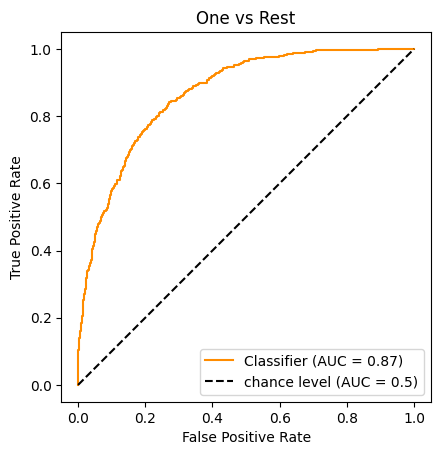

In [ ]:
import torch
import torchvision as tv
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import (ResNet18_Weights)
import torchvision.models as models
import modular.dataset as m_dataset
import modular.utility as m_utility
import modular.models as m_models


# Set seed
m_utility.set_seed(42)

# Build the dataframes
data_dir = 'data.etl'
data_folder = '512'
train_df, _, mapping = m_dataset.get_df(data_dir, data_folder)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 512

# Mapping from id to classname
idx_to_class = { k : classname for classname, k in mapping.items() }

train_df, validate_df = m_dataset.train_validate_split(train_df,
                                                       random_state=42,
                                                       validate_size=0.2)

validate_df, test_df = m_dataset.train_validate_split(validate_df,
                                                      random_state=42,
                                                      validate_size=0.5)

_, val_transforms = m_dataset.get_transforms(image_size=256)

dataset = m_dataset.MelanomaDataset(validate_df,
                                    mode='validate',
                                    transforms=val_transforms,
                                    idx_to_class=idx_to_class)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
class_names = [name for k,name in dataset.idx_to_class.items()]

out_features = len(mapping)
model = m_models.ResNet18_Dropout_Melanoma(out_features)
model = model.to(device)

model_state_dict = checkpoint['model_state_dict']
model.load_state_dict(model_state_dict)
model = model.to(device)

MEL_IDX = 6 # Check data exploration notebook

m_utility.plot_ovr_multiclass_roc(model,
                                  MEL_IDX,
                                  dataloader,
                                  device,
                                  val_times=4)

### Confusion Matrix

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1765: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


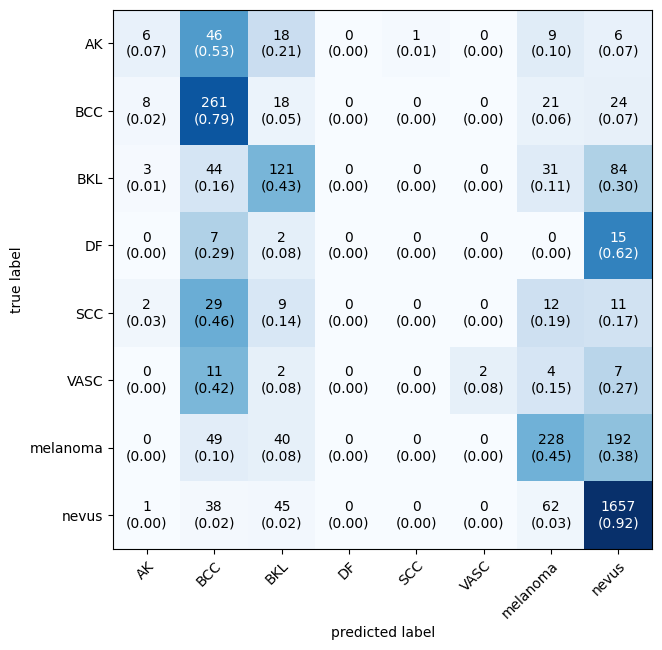

In [ ]:
import torch
import torchvision as tv
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import (ResNet18_Weights)
import torchvision.models as models
import modular.dataset as m_dataset
import modular.utility as m_utility
import modular.models as m_models


# Set seed
m_utility.set_seed(42)

# Build the dataframes
data_dir = 'data.etl'
data_folder = '512'
train_df, _, mapping = m_dataset.get_df(data_dir, data_folder)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 512

# Mapping from id to classname
idx_to_class = { k : classname for classname, k in mapping.items() }


train_df, validate_df = m_dataset.train_validate_split(train_df,
                                                       random_state=42,
                                                       validate_size=0.2)

validate_df, test_df = m_dataset.train_validate_split(validate_df,
                                                      random_state=42,
                                                      validate_size=0.5)

_, val_transforms = m_dataset.get_transforms(image_size=256)

dataset = m_dataset.MelanomaDataset(validate_df,
                                    mode='validate',
                                    transforms=val_transforms,
                                    idx_to_class=idx_to_class)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
class_names = [name for k,name in dataset.idx_to_class.items()]

out_features = len(mapping)
model = m_models.ResNet18_Dropout_Melanoma(out_features)
model = model.to(device)

model_state_dict = checkpoint['model_state_dict']
model.load_state_dict(model_state_dict)
model = model.to(device)

m_utility.plot_confusion_matrix(model,
                                dataloader,
                                class_names,
                                device,
                                show_normed=True)

### Resume

In [9]:
import torch
import torchvision as tv
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import (ResNet18_Weights)
import torchvision.models as models
import modular.dataset as m_dataset
import modular.utility as m_utility
import modular.models as m_models


# Set seed
m_utility.set_seed(42)

# Build the dataframes
data_dir = 'data.etl'
data_folder = '512'
train_df, _, mapping = m_dataset.get_df(data_dir, data_folder)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 512

# Mapping from id to classname
idx_to_class = { k : classname for classname, k in mapping.items() }


train_df, validate_df = m_dataset.train_validate_split(train_df,
                                                       random_state=42,
                                                       validate_size=0.2)

validate_df, test_df = m_dataset.train_validate_split(validate_df,
                                                      random_state=42,
                                                      validate_size=0.5)

_, val_transforms = m_dataset.get_transforms(image_size=256)

dataset = m_dataset.MelanomaDataset(validate_df,
                                    mode='validate',
                                    transforms=val_transforms,
                                    idx_to_class=idx_to_class)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
class_names = [name for k,name in dataset.idx_to_class.items()]

out_features = len(mapping)
model = m_models.ResNet18_Dropout_Melanoma(out_features)
model = model.to(device)

model_state_dict = checkpoint['model_state_dict']
model.load_state_dict(model_state_dict)
model = model.to(device)

metrics = m_utility.metrics(model,
                            dataloader,
                            device,
                            target=MEL_IDX,
                            tta_times=4,
                            as_frame=True)
metrics

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1765: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


,auc,recall,accuray
0,0.867525,0.440079,0.727767


## Test

### Melanoma VS Others (AUC - OVR)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1765: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


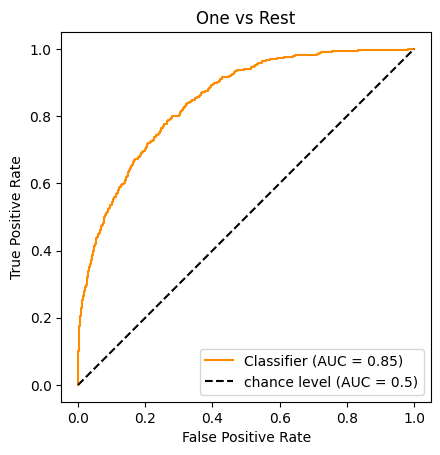

In [ ]:
import torch
import torchvision as tv
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import (ResNet18_Weights)
import torchvision.models as models
import modular.dataset as m_dataset
import modular.utility as m_utility
import modular.models as m_models


# Set seed
m_utility.set_seed(42)

# Build the dataframes
data_dir = 'data.etl'
data_folder = '512'
train_df, _, mapping = m_dataset.get_df(data_dir, data_folder)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 512

# Mapping from id to classname
idx_to_class = { k : classname for classname, k in mapping.items() }

train_df, validate_df = m_dataset.train_validate_split(train_df,
                                                       random_state=42,
                                                       validate_size=0.2)

validate_df, test_df = m_dataset.train_validate_split(validate_df,
                                                      random_state=42,
                                                      validate_size=0.5)

_, val_transforms = m_dataset.get_transforms(image_size=256)

dataset = m_dataset.MelanomaDataset(test_df,
                                    mode='validate.test',
                                    transforms=val_transforms,
                                    idx_to_class=idx_to_class)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
class_names = [name for k,name in dataset.idx_to_class.items()]

out_features = len(mapping)
model = m_models.ResNet18_Dropout_Melanoma(out_features)
model = model.to(device)

model_state_dict = checkpoint['model_state_dict']
model.load_state_dict(model_state_dict)
model = model.to(device)

MEL_IDX = 6 # Check data exploration notebook

m_utility.plot_ovr_multiclass_roc(model,
                                  MEL_IDX,
                                  dataloader,
                                  device,
                                  val_times=4)


### Confusion Matrix

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1765: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


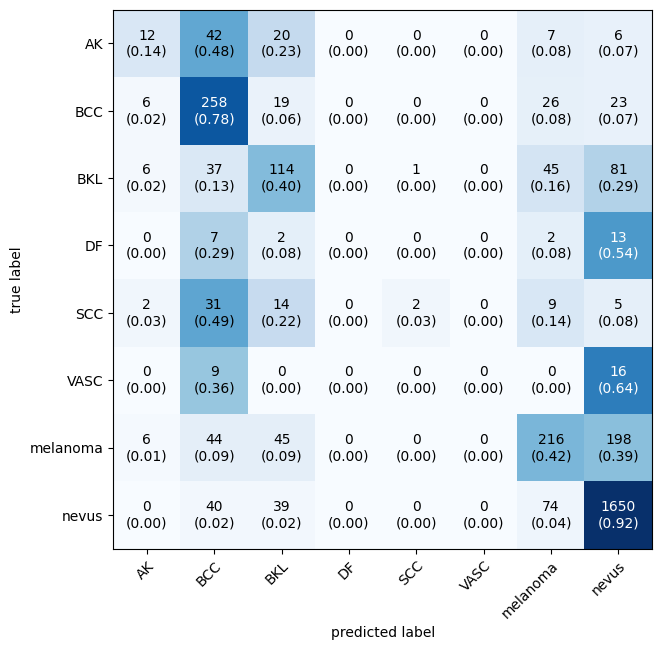

In [ ]:

import torch
import torchvision as tv
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import (ResNet18_Weights)
import torchvision.models as models
import modular.dataset as m_dataset
import modular.utility as m_utility
import modular.models as m_models


# Set seed
m_utility.set_seed(42)

# Build the dataframes
data_dir = 'data.etl'
data_folder = '512'
train_df, _, mapping = m_dataset.get_df(data_dir, data_folder)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 512

# Mapping from id to classname
idx_to_class = { k : classname for classname, k in mapping.items() }


train_df, validate_df = m_dataset.train_validate_split(train_df,
                                                       random_state=42,
                                                       validate_size=0.2)

validate_df, test_df = m_dataset.train_validate_split(validate_df,
                                                      random_state=42,
                                                      validate_size=0.5)

_, val_transforms = m_dataset.get_transforms(image_size=256)

dataset = m_dataset.MelanomaDataset(test_df,
                                    mode='validate.test',
                                    transforms=val_transforms,
                                    idx_to_class=idx_to_class)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
class_names = [name for k,name in dataset.idx_to_class.items()]

out_features = len(mapping)
model = m_models.ResNet18_Dropout_Melanoma(out_features)
model = model.to(device)

model_state_dict = checkpoint['model_state_dict']
model.load_state_dict(model_state_dict)
model = model.to(device)

m_utility.plot_confusion_matrix(model,
                                dataloader,
                                class_names,
                                device,
                                show_normed=True)

### Resume

In [10]:
import torch
import torchvision as tv
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import (ResNet18_Weights)
import torchvision.models as models
import modular.dataset as m_dataset
import modular.utility as m_utility
import modular.models as m_models


# Set seed
m_utility.set_seed(42)

# Build the dataframes
data_dir = 'data.etl'
data_folder = '512'
train_df, _, mapping = m_dataset.get_df(data_dir, data_folder)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 512

# Mapping from id to classname
idx_to_class = { k : classname for classname, k in mapping.items() }

train_df, validate_df = m_dataset.train_validate_split(train_df,
                                                       random_state=42,
                                                       validate_size=0.2)

validate_df, test_df = m_dataset.train_validate_split(validate_df,
                                                      random_state=42,
                                                      validate_size=0.5)

_, val_transforms = m_dataset.get_transforms(image_size=256)

dataset = m_dataset.MelanomaDataset(test_df,
                                    mode='validate.test',
                                    transforms=val_transforms,
                                    idx_to_class=idx_to_class)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
class_names = [name for k,name in dataset.idx_to_class.items()]

out_features = len(mapping)
model = m_models.ResNet18_Dropout_Melanoma(out_features)
model = model.to(device)

model_state_dict = checkpoint['model_state_dict']
model.load_state_dict(model_state_dict)
model = model.to(device)

MEL_IDX = 6 # Check data exploration notebook

metrics = m_utility.metrics(model,
                            dataloader,
                            device,
                            target=MEL_IDX,
                            tta_times=4,
                            as_frame=True)
metrics

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1765: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


,auc,recall,accuray
0,0.847629,0.418468,0.721778
